In [ ]:
# Author: Yuki Rivera
# This notebook contains the implementation of RNN model building, training and some evaluation
# This version of RNN utilizes an encoder-decoder structure to improve the output

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Embedding, TimeDistributed
import pandas as pd
from tensorflow.keras.models import Model
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
import matplotlib.pyplot as plt
from tensorflow.keras.losses import sparse_categorical_crossentropy
import numpy as np
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

### Parameters

In [ ]:
vocab_limit = 15000
enc_max_len = 64  # the prompt length
dec_max_len = 150   # the synopsis length
max_dec_input_length = dec_max_len - 1  # decoder input length

embedding_dim = 128 # output_dim
units = 128  # number of RNN units

batch = 64
repeat = 20 # num of epochs
patience = 3 # early-stopping patience

custom_learning_rate = 5e-5
adam_optimizer = Adam(learning_rate=custom_learning_rate)

val_ratio = 0.2 # validation set ratio

min_delta = 0.01 # minimum threshold regarded as improvement

dropout_rate = 0.3

### Preprocess the data

In [ ]:
# Cleans text
def clean_text(text):
    return text.lower().strip().replace('\n', ' ')

In [ ]:
# Loads dataset
train_df = pd.read_csv("prompt_synopsis_train.csv")

for col in ['prompt', 'synopsis']:
    train_df[col] = train_df[col].astype(str).apply(clean_text)

In [ ]:
# Defines fixed IDs for special tokens.
PAD_ID = 0
OOV_ID = 1
BOS_ID = 2
EOS_ID = 3

# Number of special tokens we manually reserve IDs for.
NUM_SPECIAL_TOKENS_RESERVED = 4 # (PAD, OOV, BOS, EOS)

# The number of actual content words the tokenizer should learn
num_words_to_fit = vocab_limit - NUM_SPECIAL_TOKENS_RESERVED

In [ ]:
# Instantiates a tokenizer (disabling special character filtering)
tokenizer = Tokenizer(num_words=num_words_to_fit, oov_token='<OOV>', filters='')
# Builds a single shared vocabulary across both the input and the output
tokenizer.fit_on_texts(train_df['prompt'].tolist() + train_df['synopsis'].tolist())

In [ ]:
# Creates a new word_index starting from our desired order.
new_word_index = {}
new_index_word = {}

# Assigns reserved IDs first
new_word_index["<PAD>"] = PAD_ID
new_index_word[PAD_ID] = "<PAD>"

new_word_index["<OOV>"] = OOV_ID
new_index_word[OOV_ID] = "<OOV>"

new_word_index["<BOS>"] = BOS_ID
new_index_word[BOS_ID] = "<BOS>"

new_word_index["<EOS>"] = EOS_ID
new_index_word[EOS_ID] = "<EOS>"

In [ ]:
# Starts assigning IDs from the next available slot after special tokens.
next_available_id = NUM_SPECIAL_TOKENS_RESERVED
content_words_assigned = 0 # Tracks how many content words we've assigned

for word, original_id in sorted(tokenizer.word_index.items(), key=lambda item: item[1]):
    # Skips words not in the new word index
    if word in new_word_index:
        continue
    # Assigns the new ID to the content word
    if content_words_assigned < num_words_to_fit:
        new_word_index[word] = next_available_id
        new_index_word[next_available_id] = word
        next_available_id += 1
        content_words_assigned += 1

    else:
        # Breaks the loop once all required content words have been assigned
        break


tokenizer.word_index = new_word_index
tokenizer.index_word = new_index_word

# Ensures the vocab_size for Embedding layer stays the same as the target vocab limit
vocab_size = vocab_limit

### Saves the tokenizer

In [ ]:
with open("tokenizer_RNN.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

### Converts words into token IDs and creates sequences

In [ ]:
# Converts each prompt or synopsis into a list of integers
input_seqs = tokenizer.texts_to_sequences(train_df['prompt'])
output_seqs = tokenizer.texts_to_sequences(train_df['synopsis'])

# Adds BOS and EOS tokens to each synopsis sequence
synopsis_token_ids_augmented = [[BOS_ID] + seq + [EOS_ID] for seq in output_seqs]

# Creates decoder inputs that goes into the decoder during training
decoder_input_ids = [seq[:-1] for seq in synopsis_token_ids_augmented]

# Create decoder targets for loss calculation
decoder_target_ids = [seq[1:] for seq in synopsis_token_ids_augmented]

### Pads sequences

In [ ]:
# Encoder input (prompts)
padded_input = pad_sequences(input_seqs, maxlen=enc_max_len, truncating='post', padding='post', value=0)

# Decoder input for training
decoder_input_data = pad_sequences(decoder_input_ids, maxlen=max_dec_input_length, truncating='post', padding='post', value=0)

# Decoder target for training (needs to be expanded for sparse_categorical_crossentropy)
decoder_target_data = pad_sequences(decoder_target_ids, maxlen=max_dec_input_length, truncating='post', padding='post', value=0)
decoder_target_data = np.expand_dims(decoder_target_data, axis=-1)

### Defines RNN Model

In [ ]:
#### Encoder ####

# Input layer for the encoder (prompts)
encoder_inputs = Input(shape=(enc_max_len,), name='encoder_input')

# Embedding layer for the encoder inputs
# `mask_zero=True` to ignore padding (token ID 0) during processing.
encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, name='encoder_embedding')(encoder_inputs)

# Encoder SimpleRNN layer.
# `return_state=True` to make the RNN layer return its final hidden state along with its outputs.
encoder_rnn = SimpleRNN(units, return_state=True, name='encoder_rnn')
encoder_outputs, state_h = encoder_rnn(encoder_embedding)

# `encoder_states` holds the final hidden state of the encoder.
encoder_states = state_h


#### Decoder ####

# Input layer for the decoder (shifted target synopsis sequences, thus dec_max_len -1 for the shape)
decoder_inputs = Input(shape=(dec_max_len - 1,), name='decoder_input')

# Embedding layer for the decoder inputs.
# `mask_zero=True` is for the decoder's input to ignore padding.
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, name='decoder_embedding')(decoder_inputs)

# Decoder SimpleRNN layer.
# `return_sequences=True` ensures that the RNN outputs a sequence, not just a single final output.
# `initial_state=encoder_states` connects the encoder to the decoder.
decoder_rnn = SimpleRNN(units, return_sequences=True, return_state=True, name='decoder_rnn')
decoder_outputs_sequence, decoder_state_h = decoder_rnn(decoder_embedding, initial_state=encoder_states)

# Dense layer at the end of the decoder.
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')
output = decoder_dense(decoder_outputs_sequence)


#### Defines the Encoder-Decoder model ####
model_rnn = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)

### Callbacks for saving the best model & early stopping

In [ ]:
# Saves the best model
checkpoint_callback = ModelCheckpoint(
    "best_model_RNN.keras",   
    save_best_only=True,  
    monitor='val_loss',   
    mode='min',           
    verbose = 1           
)

# Stops early if val_loss stops improving
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=patience,
    min_delta=min_delta,
    restore_best_weights=True,
    verbose = 1
)

### Prepare training and validation sets

In [ ]:
X = [padded_input, decoder_input_data]
y = decoder_target_data

# Performs the split
X_train_encoder, X_val_encoder, X_train_decoder, X_val_decoder, y_train_target, y_val_target = train_test_split(
    X[0], X[1], y, test_size=val_ratio, random_state=42
)

### Configures the model to train

In [ ]:
model_rnn.compile(
    optimizer=adam_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Trains the model with validation data and callbacks included

In [ ]:
full_history = []

In [ ]:
# Combine encoder and decoder inputs for the training set
train_inputs = [X_train_encoder, X_train_decoder]
# Combine encoder and decoder inputs for the validation set
val_inputs = [X_val_encoder, X_val_decoder]

In [ ]:
# trains the model with teacher-forcing
history1 = model_rnn.fit(
    train_inputs,       # List of training inputs for encoder and decoder
    y_train_target,     # Training target
    batch_size=batch,
    epochs=repeat,      # Set a higher number of epochs, EarlyStopping will stop it
    validation_data=(val_inputs, y_val_target), # Pass the split validation data
    callbacks=[checkpoint_callback, early_stopping], # Pass the list of callbacks here
    verbose=1,
    shuffle=True
)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0275 - loss: 8.4605
Epoch 1: val_loss improved from inf to 6.66194, saving model to best_model_RNN.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - accuracy: 0.0275 - loss: 8.4594 - val_accuracy: 0.0534 - val_loss: 6.6619
Epoch 2/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0540 - loss: 6.6293
Epoch 2: val_loss improved from 6.66194 to 6.61548, saving model to best_model_RNN.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.0540 - loss: 6.6293 - val_accuracy: 0.0534 - val_loss: 6.6155
Epoch 3/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0538 - loss: 6.6080
Epoch 3: val_loss improved from 6.61548 to 6.58175, saving model to best_model_RNN.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.0538 - loss: 6.6080 - val_accuracy: 0.0534 - val_loss: 6.5817
Epoch 4/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0543 - loss: 6.5446
Epoch 4: val_loss improved from 

In [ ]:
full_history.append(history1.history)

### Second round training if necessary

In [ ]:
# model_rnn.load_weights("best_model_RNN.keras")

In [ ]:
# # trains the model with teacher-forcing
# history2 = model_rnn.fit(
#     train_inputs,       # List of training inputs for encoder and decoder
#     y_train_target,     # Training target
#     batch_size=batch,
#     initial_epoch=repeat,
#     epochs=120,
#     validation_data=(val_inputs, y_val_target), # Pass the split validation data
#     callbacks=[checkpoint_callback, early_stopping], # Pass the list of callbacks here
#     verbose=1 # Show training progress
# )

In [ ]:
# full_history.append(history2.history)

### Combines the training history

In [ ]:
combined = {
    "loss": sum([h["loss"] for h in full_history], []),
    "val_loss": sum([h["val_loss"] for h in full_history], []),
}

### Save the tokenizer

In [ ]:
with open("tokenizer_RNN.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

### Save the training history

In [ ]:
with open("combined_history.pkl", "wb") as f:
    pickle.dump(combined, f)

### Plot the Loss Curve

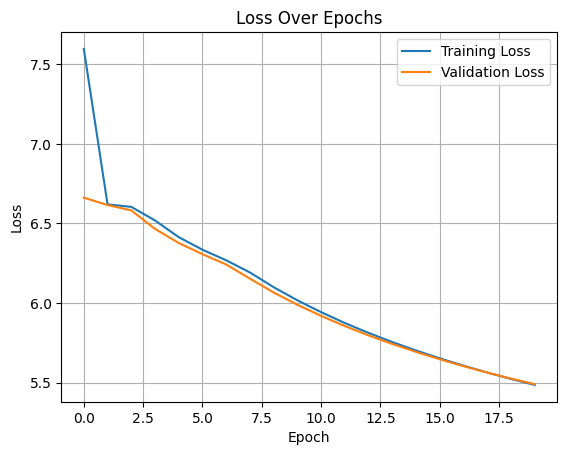

In [ ]:
# Plot training & validation loss
plt.plot(combined['loss'], label='Training Loss')
plt.plot(combined['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve_RNN.png')
plt.show()

### Perplexity calculation

In [ ]:
model_rnn.load_weights("best_model_RNN.keras")

In [ ]:
val_perplexities = []

val_loss, val_accuracy = model_rnn.evaluate(val_inputs, y_val_target, verbose=0)
perplexity = np.exp(val_loss)

### Saves parameters and perplexity

In [ ]:
parameters = {'epochs':repeat, 'batch_size':batch, 'embedding_dim':embedding_dim,
              'RNN units':units, 'vocab_limit':vocab_limit, 'learning_rate':custom_learning_rate,'patience':patience,
              'min_delta':min_delta, 'validation_ratio':val_ratio, 'dropout':dropout_rate, 'perplexity':perplexity}

results = ''
for key, value in parameters.items():
    results += "{key}: {value}".format(key=key, value=value)
    results += '\n'

with open('results_RNN.txt', 'w') as f:
    f.write(results)